In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import xgboost as xgb

from sklearn.preprocessing import OrdinalEncoder

from util import *

plt.rcParams['axes.linewidth'] = 1.5
font = {'family' : 'DejaVu Sans',
       'weight' : 'normal',
       'size' : 12.0}
plt.rc('font',**font)

In [24]:
path = 'C:/Users/sjurg/OneDrive/Documents/Python/misc_data_sets/ieee-fraud-detection.zip'
sample_name = 'sample_submission.csv'
train_transaction_name = 'train_transaction.csv'
#sample_sub = zipped_csv_to_df(path, sample_name)
train_trans = zipped_csv_to_df(path, train_transaction_name)

In [28]:
train_trans['V258'].isna().sum()

460110

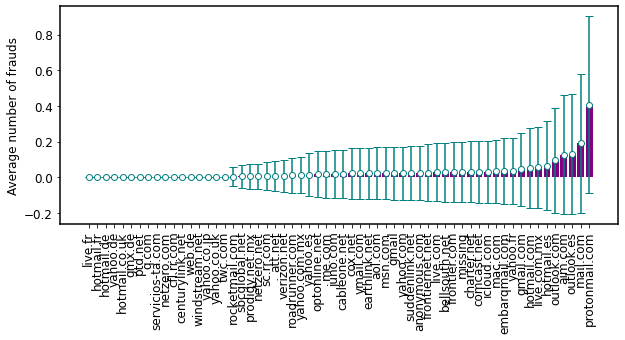

In [3]:
# Look at how the average number of frauds varies across the different email domains.
# This as an example of a basic (visual) ANOVA. There is no clear distinction between the 
# average fraud rates for the different email domains used.

train_trans['P_emaildomain'] = train_trans['P_emaildomain'].mask(train_trans['P_emaildomain'].isna(),
                                                                 'missing')

group_edom = train_trans.groupby('P_emaildomain')
frauds_per_edom = group_edom['isFraud'].sum()
mean_frauds_per_edom = group_edom['isFraud'].mean()
idx = mean_frauds_per_edom.values.argsort().tolist()
std_frauds_per_edom = group_edom['isFraud'].std()

n = len(mean_frauds_per_edom.keys().tolist())

fig, ax = plt.subplots(1,1,figsize=(10,4))
ax.bar(np.array(mean_frauds_per_edom.keys())[idx], np.array(mean_frauds_per_edom.values)[idx], 
       align='center', 
       color='purple', 
       label='Average value')
ax.errorbar(np.arange(n), np.array(mean_frauds_per_edom.values)[idx], 
                   yerr=np.array(std_frauds_per_edom.values)[idx], 
                   linestyle = '', capsize=4, color='teal', 
                   marker='o', markerfacecolor = 'white')
ax.set_ylabel('Average number of frauds')
plt.xticks(rotation='vertical');

In [4]:
train_trans = reduce_data_size(train_trans)

In [5]:
train_trans.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
new_feat_list = get_low_missing_features(train_trans, 200000)
train_trans = ordinal_encoding(train_trans)[new_feat_list]

In [7]:
print('number of NON fraudulent transations {}'.format(len(train_trans[new_feat_list].
                                                    query('isFraud == 0')['isFraud'])))
print('number of fraudulent transations {}'.format(len(train_trans[new_feat_list].
                                                    query('isFraud == 1')['isFraud'])))

number of NON fraudulent transations 569877
number of fraudulent transations 20663


In [8]:
X, Y = train_trans.drop(['TransactionID', 'TransactionDT', 'isFraud'], axis=1), train_trans['isFraud']

In [9]:
from xgboost import XGBClassifier

model = XGBClassifier(scale_pos_weight=30, n_estimators=100, max_depth=2)

model.fit(X, Y)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=2, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [10]:
test_trans = zipped_csv_to_df(path, 'test_transaction.csv')

In [11]:
test_trans = reduce_data_size(test_trans)

In [12]:
new_feat_list.remove('isFraud')
test_trans = ordinal_encoding(test_trans)[new_feat_list]

In [13]:
X_test = test_trans.drop(['TransactionID', 'TransactionDT'], axis=1)

In [14]:
res = model.predict_proba(X_test)

In [18]:
pred_path = 'C:/Users/sjurg/OneDrive/Documents/Python/DS-ML_Projects/ieee_fraud_detection/predictions/'
predictions = pd.DataFrame({'TransactionID': test_trans['TransactionID'], 'isFraud': res[:, 1]})
predictions.to_csv(pred_path + "predictions1.csv", index=False) 

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

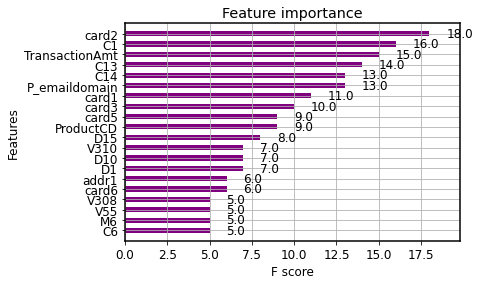

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
xgb.plot_importance(model, max_num_features=20, height=0.5, ax=ax, color='purple')